In [137]:

import torch

import numpy as np
import open_clip
from open_clip import tokenizer

In [138]:
path2text = './general.txt'

prompts_list = []

with open(path2text, 'r') as f:
    for line in f:
        prompts_list.append(line.strip())


In [139]:
print(prompts_list[:10])

['A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.', 'A mystical forest with a majestic unicorn standing in a clearing, surrounded by glowing flowers.', 'A vibrant underwater world with colorful coral reefs, schools of tropical fish, and a mermaid swimming by.', 'An otherworldly landscape with floating islands, strange rock formations, and a massive portal in the sky.', 'A bustling market in a foreign city, filled with exotic spices, fruits, and handcrafted goods.', 'A dramatic space battle between a fleet of starships and a massive alien mothership, with laser beams and explosions lighting up the scene.', 'A serene mountain landscape with a tranquil lake, towering pine trees, and a small cabin nestled in the woods.', 'A romantic scene with a couple dancing in a moonlit garden, surrounded by blooming flowers and twinkling stars.', 'A post-apocalyptic wasteland with ruins of buildings, abandoned vehicles, and survivors scavenging for resources.', 'A glamor

In [140]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', )

In [141]:
text_tokens = tokenizer.tokenize(prompts_list)
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()

In [142]:

# comput cosine similarity
cos_sim = np.dot(text_features, text_features.T) / (np.linalg.norm(text_features, axis=1)[:, None] * np.linalg.norm(text_features, axis=1)[None, :])
# delete the diagonal entries from the matrix
for i in range(len(cos_sim)):
    cos_sim[i][i] = 1.0

# find the closest text prompts using cosine similarity
top_k = 2
closest_ids = cos_sim.argsort(axis=1)[:, -top_k:][:, ::-1]

for prompt, closest_id in zip(prompts_list, closest_ids):
    print(prompt)
    for idx in closest_id[1:]: # exclude the first one, which is the prompt itself
        print(prompts_list[idx])
    break

A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.
A futuristic cityscape scene with sleek skyscrapers, flying cars, and neon lights.


In [143]:
from sklearn.cluster import KMeans

k = 10

distance_matrix = cos_sim

# k-means clustering
# finds the closest point to the centroid of each cluster
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=33, n_init=100, max_iter=1000)
kmeans.fit(distance_matrix)

centroids = kmeans.cluster_centers_

k_points = []
for i in range(k):
    # find the closest point to the centroid of each cluster
    # that ensures that points will be spread out
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    closest_point = cluster_indices[np.argmin(distance_matrix[cluster_indices][:, cluster_indices].sum(axis=0))]
    k_points.append(closest_point)

print(k_points)

[120, 5, 105, 113, 199, 127, 162, 103, 130, 159]


In [144]:
temp = cos_sim[k_points, :][:, k_points]
temp = temp - np.eye(temp.shape[0])

dissimilarity_coef = (temp.sum() // 2) / (temp.shape[0] * (temp.shape[0] - 1) / 2)
print(f"Mean distance, i.e. cosine similarity, is {round(dissimilarity_coef, 4)}")

Mean distance, i.e. cosine similarity, is 0.4889


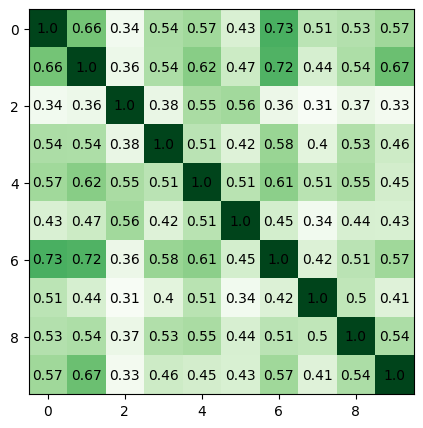

In [145]:
# distance between the most dissimilar prompts
# plot it color coded as a heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(cos_sim[k_points, :][:, k_points], cmap='Greens', interpolation='nearest')
# put values in the cells
for i in range(k):
    for j in range(k):
        plt.text(j, i, round(cos_sim[k_points[i]][k_points[j]], 2), ha='center', va='center', color='black')
plt.show()


In [146]:
# Most dissimilar prompts
for idx in k_points:
    print(prompts_list[idx])

A surreal and otherworldly scene of an alien landscape with strange rock formations and a glowing sky.
A dramatic space battle between a fleet of starships and a massive alien mothership, with laser beams and explosions lighting up the scene.
A vibrant and colorful scene of a street market in Marrakech, Morocco with spices, textiles, and street performers.
A haunting and eerie scene of an abandoned amusement park at night, with rusted rides and flickering lights.
A postcard-perfect Italian village with narrow streets, terracotta roofs, and a picturesque town square with a fountain.
A vibrant and colorful scene of a Carnaval parade in Rio de Janeiro with samba dancers, costumes, and floats.
A post-apocalyptic world with a group of survivors trekking across a barren wasteland, with a radioactive sunset in the background.
A serene and peaceful scene in a Japanese garden with a koi pond, stone lanterns, and cherry blossom trees.
A romantic and whimsical scene of a couple dancing under the 

In [147]:
# find the index of the maximum value in the matrix temp
i, j = np.unravel_index(np.argmax(temp), temp.shape)
print(f"Most similar prompts are: \n{prompts_list[k_points[i]]} \n{prompts_list[k_points[j]]}")


Most similar prompts are: 
A surreal and otherworldly scene of an alien landscape with strange rock formations and a glowing sky. 
A post-apocalyptic world with a group of survivors trekking across a barren wasteland, with a radioactive sunset in the background.
